In [1]:
from minisom import MiniSom
import numpy as np
import pandas as pd

In [278]:
train = pd.read_csv('data/etrain.csv')
validation = pd.read_csv('data/evalidation.csv')
test = pd.read_csv('data/etest.csv')
features = np.load('selected_features.npy', allow_pickle=True)

In [3]:
def classify(som, data, x_train, y_train):
    """Classifies each sample in data in one of the classes definited
    using the method labels_map.
    Returns a list of the same length of data where the i-th element
    is the class assigned to data[i].
    """
    winmap = som.labels_map(x_train, y_train)
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

In [432]:
from sklearn.metrics import classification_report

x_train = train[features].values
y_train = train['target'].values
x_validation = validation[features].values
y_validation = validation['target'].values
x_test = test[features].values
y_test = test['target'].values

size_x = 2
size_y = 3
som = MiniSom(size_x, size_y, len(features), sigma=1, learning_rate=1.2, 
              neighborhood_function='triangle', random_seed=10)
som.random_weights_init(x_train)
som.train_random(x_train, 500, verbose=True)

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 1.7206787447342262


In [433]:
som.topographic_error(x_train)

0.4374905972619227

In [434]:
import xgboost as xgb
from sklearn.metrics import classification_report
rng = np.random.RandomState(31337)

models = [xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.04, objective='multi:softmax', booster='gbtree',
                              reg_alpha=2.0, reg_lambda=2.5, gamma=0.5, min_child_weight=2.0, colsample_bytree=0.7,
                              subsample=0.5, use_label_encoder=False, n_jobs=-1, random_state=1) for i in range(size_x*size_y)]

# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in x_train]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, (size_x, size_y))

for c in np.unique(cluster_index):
    models[c].fit(x_train[cluster_index == c], y_train[cluster_index == c], verbose=False)
    
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in x_train]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, (size_x, size_y))
for c in np.unique(cluster_index):
    print(classification_report(y_train[cluster_index == c], models[c].predict(x_train[cluster_index == c]), zero_division=True))


[09:11:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:11:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:11:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:11:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

In [441]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in x_validation]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, (size_x, size_y))
results_validation = []
for c in np.unique(cluster_index):
    tmp = classification_report(y_validation[cluster_index == c], models[c].predict(x_validation[cluster_index == c]), zero_division=True)
    print(tmp)
    results_validation.append(classification_report(y_validation[cluster_index == c], models[c].predict(x_validation[cluster_index == c]), zero_division=True, output_dict=True))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       311
           1       0.66      0.67      0.67       500
           2       0.68      0.71      0.69       525
           3       0.90      0.84      0.87       507

    accuracy                           0.75      1843
   macro avg       0.75      0.75      0.75      1843
weighted avg       0.75      0.75      0.75      1843

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       352
           1       0.63      0.54      0.58       290
           2       0.65      0.67      0.66       354
           3       0.85      0.84      0.85       425

    accuracy                           0.75      1421
   macro avg       0.73      0.74      0.73      1421
weighted avg       0.74      0.75      0.75      1421

              precision    recall  f1-score   support

           0       0.78      0.64      0.70        80
           1       0.

In [442]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in x_test]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, (size_x, size_y))
results_test = []
for c in np.unique(cluster_index):
    tmp = classification_report(y_test[cluster_index == c], models[c].predict(x_test[cluster_index == c]), zero_division=True)
    print(tmp)
    results_test.append(classification_report(y_test[cluster_index == c], models[c].predict(x_test[cluster_index == c]), zero_division=True, output_dict=True))

              precision    recall  f1-score   support

           0       0.78      0.75      0.76       377
           1       0.65      0.73      0.68       598
           2       0.71      0.68      0.69       668
           3       0.88      0.85      0.87       642

    accuracy                           0.75      2285
   macro avg       0.76      0.75      0.75      2285
weighted avg       0.75      0.75      0.75      2285

              precision    recall  f1-score   support

           0       0.82      0.86      0.84       472
           1       0.60      0.56      0.58       374
           2       0.65      0.69      0.67       455
           3       0.87      0.82      0.85       518

    accuracy                           0.74      1819
   macro avg       0.73      0.73      0.73      1819
weighted avg       0.75      0.74      0.74      1819

              precision    recall  f1-score   support

           0       0.83      0.59      0.69        88
           1       0.

In [446]:
print("Validation")
f_score = 0
accuracy = 0
total = len(x_validation)
for result in results_validation:
    f_score += result['weighted avg']['f1-score'] * (result['weighted avg']['support'] / total)
    accuracy += result['accuracy'] * (result['weighted avg']['support'] / total)

print('weighted avg f_score: ', f_score)
print('weighted avg accuracy: ', accuracy)

Validation
weighted avg f_score:  0.769084777151489
weighted avg accuracy:  0.7705731909131939


In [447]:
print("Test")
f_score = 0
accuracy = 0
total = len(x_test)
for result in results_test:
    f_score += result['weighted avg']['f1-score'] * (result['weighted avg']['support'] / total)
    accuracy += result['accuracy'] * (result['weighted avg']['support'] / total)

print('weighted avg f_score: ', f_score)
print('weighted avg accuracy: ', accuracy)

Test
weighted avg f_score:  0.7660921535905365
weighted avg accuracy:  0.7671199903718859


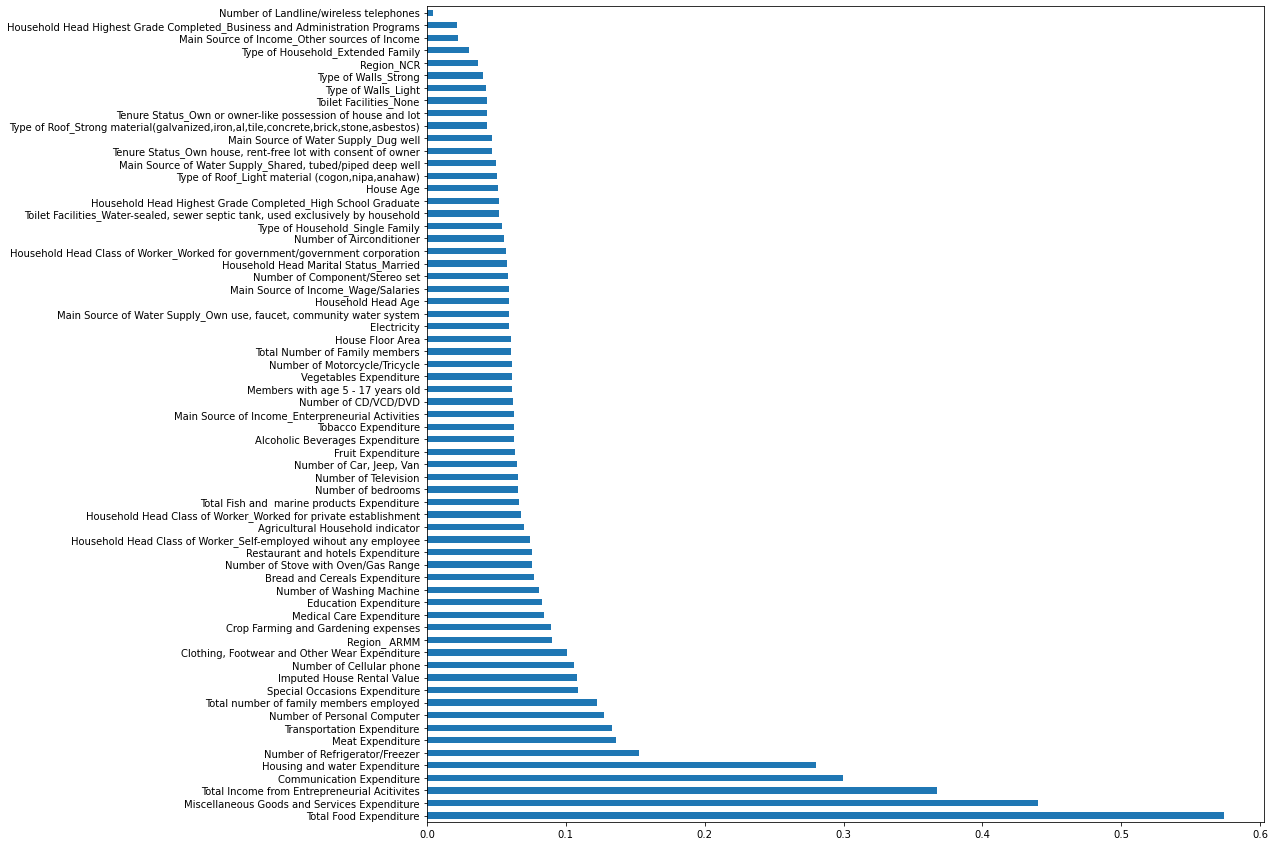

In [448]:
feature_importances = np.array([[models[i].feature_importances_] for i in range(size_x*size_y)])

feat_importances = pd.Series(feature_importances.sum(axis=0).ravel(), index=features)
plt.figure(figsize=(15, 15))
f = feat_importances.nlargest(features.shape[0])
f.plot(kind='barh')
plt.show()